# Prediction of Test Stock Prices

## Data preparation

In [19]:

import torch
import numpy as np
import pandas as pd


data = pd.read_csv('data/TSLA.csv')
data = data.dropna()
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [20]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.000000,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.420000,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.920000,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.100000,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.000000,15.830000,16.110001,16.110001,6866900
...,...,...,...,...,...,...,...
2411,2020-01-28,568.489990,576.809998,558.080017,566.900024,566.900024,11788500
2412,2020-01-29,575.690002,589.799988,567.429993,580.989990,580.989990,17801500
2413,2020-01-30,632.419983,650.880005,618.000000,640.809998,640.809998,29005700
2414,2020-01-31,640.000000,653.000000,632.520020,650.570007,650.570007,15719300


### Normalization

In [21]:
data.drop(['Date'], axis=1, inplace=True)
means = data.mean(axis=0)
stds = data.std(axis=0)

data = (data-means) / stds
data.head()

,Open,High,Low,Close,Adj Close,Volume
0,-1.408716,-1.361362,-1.415198,-1.364102,-1.364102,2.645165
1,-1.351532,-1.316529,-1.365907,-1.364605,-1.364605,2.328553
2,-1.358185,-1.353752,-1.391836,-1.380302,-1.380302,0.530509
3,-1.375029,-1.377078,-1.405186,-1.403468,-1.403468,-0.086796
4,-1.400294,-1.402721,-1.429831,-1.429405,-1.429405,0.259468


### Change dataframe to Tensor

In [22]:
torch.cuda.is_available()

False

In [23]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

ratio_trains = 0.8
trains = int ( len(data)* ratio_trains )

targets = torch.FloatTensor(data['Close'].values).to(device)
inputs = torch.FloatTensor(data[['Open', 'High', 'Low', 'Volume']].values).to(device)

targets_train = targets[:trains]
targets_test = targets[trains:]

inputs_train = inputs[:trains]
inputs_test = inputs[trains:]
print(inputs_train.shape, targets_train.shape, inputs_test.shape, targets_test.shape)

torch.Size([1932, 4]) torch.Size([1932]) torch.Size([484, 4]) torch.Size([484])


## Dataset

In [24]:
from torch.utils.data import TensorDataset

dataset_train = TensorDataset(inputs_train, targets_train) #tuple of inputs and targets
dataset_test = TensorDataset(inputs_test, targets_test) #tuple of inputs and targets

## Dataloading

In [25]:
from torch.utils.data import DataLoader

batch_size = 256
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

# Batch Sampling
for input,target in train_loader:
    print(input.shape, target.shape)


torch.Size([256, 4]) torch.Size([256])
torch.Size([256, 4]) torch.Size([256])
torch.Size([256, 4]) torch.Size([256])
torch.Size([256, 4]) torch.Size([256])
torch.Size([256, 4]) torch.Size([256])
torch.Size([256, 4]) torch.Size([256])
torch.Size([256, 4]) torch.Size([256])
torch.Size([140, 4]) torch.Size([140])


## Design a neural network

In [26]:
# Linear Regression Model
from torch import nn
class linearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.norm = nn.BatchNorm1d(4)
        self.linear = nn.Linear(4, 1)  # input and output is 1 dimension
    def forward(self, x):
        x = self.norm(x)
        out = self.linear(x)
        return out

model = linearRegression().to(device)


model = torch.nn.Sequential(
    # nn.BatchNorm1d(4),
    nn.Linear(4,100),
    nn.ReLU(),
    nn.Linear(100,1),
)
model = model.to(device)

In [27]:
train_loader

## Training

In [28]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

num_epochs = 2000
for epoch in range(num_epochs):    
    for input, target in train_loader:
        optimizer.zero_grad()
        pred = model(input)
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()
        print(f'Epoch[{epoch+1}/{num_epochs}], loss: {loss.item():.6f}')



#for name, param in model.named_parameters():
#    print (name, param.data.numpy(), end=' ')


Epoch[1/2000], loss: 0.976627
Epoch[1/2000], loss: 1.107838
Epoch[1/2000], loss: 1.026613
Epoch[1/2000], loss: 1.049633
Epoch[1/2000], loss: 1.020722
Epoch[1/2000], loss: 0.969976
Epoch[1/2000], loss: 1.145212
Epoch[1/2000], loss: 0.973900
Epoch[2/2000], loss: 1.065874
Epoch[2/2000], loss: 1.025365
Epoch[2/2000], loss: 0.923258
Epoch[2/2000], loss: 0.954586
Epoch[2/2000], loss: 0.972246
Epoch[2/2000], loss: 0.994512
Epoch[2/2000], loss: 0.946966
Epoch[2/2000], loss: 1.047905
Epoch[3/2000], loss: 0.989355
Epoch[3/2000], loss: 0.950685
Epoch[3/2000], loss: 0.910545
Epoch[3/2000], loss: 0.968066
Epoch[3/2000], loss: 1.005790
Epoch[3/2000], loss: 0.946210
Epoch[3/2000], loss: 0.951501
Epoch[3/2000], loss: 0.877081
Epoch[4/2000], loss: 0.940653
Epoch[4/2000], loss: 0.889588
Epoch[4/2000], loss: 0.985620
Epoch[4/2000], loss: 0.911169
Epoch[4/2000], loss: 0.890419
Epoch[4/2000], loss: 0.912416
Epoch[4/2000], loss: 0.997067
Epoch[4/2000], loss: 0.918739
Epoch[5/2000], loss: 0.846034
Epoch[5/20

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([140])) that is different to the input size (torch.Size([140, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch[8/2000], loss: 0.851877
Epoch[8/2000], loss: 0.905798
Epoch[8/2000], loss: 0.850668
Epoch[8/2000], loss: 0.948985
Epoch[9/2000], loss: 1.010960
Epoch[9/2000], loss: 0.834244
Epoch[9/2000], loss: 0.844864
Epoch[9/2000], loss: 0.862957
Epoch[9/2000], loss: 0.843633
Epoch[9/2000], loss: 0.902645
Epoch[9/2000], loss: 0.876485
Epoch[9/2000], loss: 0.915485
Epoch[10/2000], loss: 0.890552
Epoch[10/2000], loss: 0.909524
Epoch[10/2000], loss: 0.890200
Epoch[10/2000], loss: 0.851590
Epoch[10/2000], loss: 0.841689
Epoch[10/2000], loss: 0.932681
Epoch[10/2000], loss: 0.877669
Epoch[10/2000], loss: 0.848541
Epoch[11/2000], loss: 0.847399
Epoch[11/2000], loss: 0.878566
Epoch[11/2000], loss: 0.797317
Epoch[11/2000], loss: 0.922619
Epoch[11/2000], loss: 0.884200
Epoch[11/2000], loss: 0.937533
Epoch[11/2000], loss: 0.928065
Epoch[11/2000], loss: 0.801360
Epoch[12/2000], loss: 0.840878
Epoch[12/2000], loss: 0.863342
Epoch[12/2000], loss: 0.858801
Epoch[12/2000], loss: 0.903232
Epoch[12/2000], loss

## Evaluation

Prediction: 
 tensor([[-0.2264],
        [-0.2362],
        [-0.2362],
        [-0.2380],
        [-0.2493],
        [-0.2348],
        [-0.2376],
        [-0.2333],
        [-0.2505],
        [-0.2306],
        [-0.2545],
        [-0.2413],
        [-0.2039],
        [-0.2410],
        [-0.2388],
        [-0.2348],
        [-0.3452],
        [-0.1997],
        [-0.2350],
        [-0.2413],
        [-0.2345],
        [-0.2516],
        [-0.2320],
        [-0.2648],
        [-0.2333],
        [-0.3174],
        [-0.2353],
        [-0.2319],
        [-0.2368],
        [-0.2365],
        [-0.2468],
        [-0.2339],
        [-0.2232],
        [-0.2504],
        [-0.2436],
        [-0.2384],
        [-0.2503],
        [-0.2285],
        [-0.2348],
        [-0.2367],
        [-0.1933],
        [-0.2508],
        [-0.2313],
        [-0.2373],
        [-0.2648],
        [-0.2357],
        [-0.2330],
        [-0.2387],
        [-0.2294],
        [-0.2148],
        [-0.2404],
        [-0.2345]

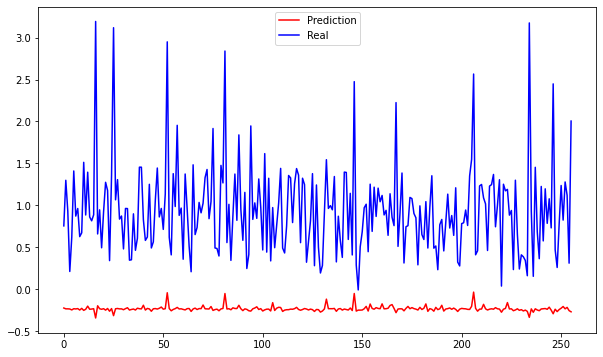

In [29]:
import matplotlib.pyplot as plt


model.eval()
input, target = next(iter(test_loader))
pred = model(input)
print("Prediction: \n",pred.data)
print("Real:", target.data)

plt.figure(figsize = (10,6))
plt.plot(pred.data.cpu(),'r-', label='Prediction')
plt.plot(target.data.cpu(),'b-', label='Real')
plt.legend()
plt.show()